In [225]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from datetime import timedelta
from timeit import default_timer as timer
from math import sqrt

## Images reading&resizing

In [228]:
img_l = np.asanyarray(Image.open("a2.jpg").resize((400,300), Image.BICUBIC).convert("RGB")).astype(np.int)
img_r = np.asanyarray(Image.open("a2.jpg").resize((400,300), Image.BICUBIC).convert("RGB")).astype(np.int)

## Params definition

In [229]:
kg_max=45
kv_max=14
kv_half = kv_max//2
height = img_r.shape[0]
length = img_r.shape[1]

In [230]:
#import shelve

In [231]:
#with shelve.open("lab2.db") as db:
    #db["img_shift2"] = img_shift2
    #img_shift2 = db["img_shift2"]

In [232]:
#np.save("img_shift.npy", img_shift2)

In [233]:
img_shift2 = np.load("img_shift.npy")

In [234]:
from scipy import ndimage

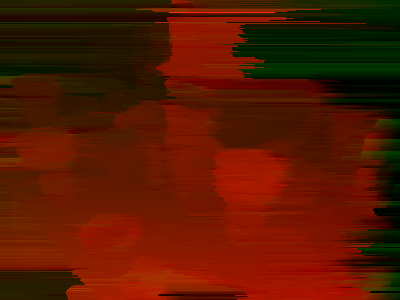

In [235]:
#k = np.ones((3,3))/9
#img_shift2[:,:,0] = ndimage.convolve(img_shift2[:,:,0], k, mode='reflect')
#img_shift2[:,:,1] = ndimage.convolve(img_shift2[:,:,1], k, mode='reflect')
Image.fromarray((255.9*img_shift2/img_shift2.max()).astype(np.uint8))

# lab2 start

https://staff.fnwi.uva.nl/l.dorst/hz/chap11_13.pdf

In [236]:
from random import choices
from scipy.linalg import null_space

In [237]:
def is_smooth(img_shift, x, y, radius=1):
    for i in range(-radius,radius+1):
        for j in range(-radius,radius+1):
            if np.any(img_shift[y, x] != img_shift[y+i, x+j]):
                return False
    return True


map2draw = np.zeros((img_r.shape), dtype=np.uint8)

pairs = []
rejected_pairs = []
# (X, X')
for y_r in range(30, img_r.shape[0] - 30):
    for x_r in range(30, img_r.shape[1] - 30):
        x_r3d = [x_r - 200, y_r - 150, 1]
        
        dot_shift = img_shift2[y_r, x_r]
        
        x_l = int(x_r + dot_shift[0])
        y_l = int(y_r + (dot_shift[1] - kv_half))
        x_l3d = [x_l - 200, y_l - 150, 1]
        
        if is_smooth(img_shift2, x_r, y_r):
            pairs.append([x_l3d, x_r3d])
            map2draw[y_r, x_r] = 255
        else:
            rejected_pairs.append([x_l3d, x_r3d])

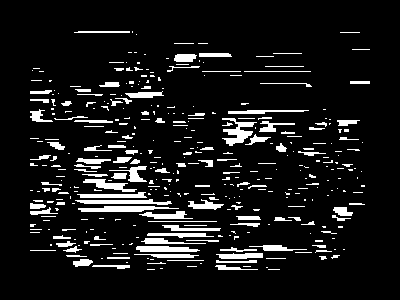

In [238]:
Image.fromarray(map2draw)

In [239]:
len(pairs)

11374

In [240]:
len(rejected_pairs)

70226

In [241]:
Boundary = 1e-3
bestF = None
bestScore = 0

all_right = np.array([i[1] for i in pairs])
all_left = np.array([i[0] for i in pairs])

for iteration in range(5000):
    seven_pairs = choices(pairs, k=7)
    X_big = []
    for left, right in seven_pairs:
        x_l, y_l, z_l = left
        x_r, y_r, z_r = right
        X_big.append([x_r*x_l, x_r*y_l, x_r*z_l,
                      y_r*x_l, y_r*y_l, y_r*z_l,
                      z_r*x_l, z_r*y_l, z_r*z_l])
        # на попередній лінії була помилка,
        # через яку я декілька тижнів не міг зрозуміти чого не працює.
        # вічна пам'ять моїм загиблим нервовим клітинам.
        # F
    X_big = np.array(X_big)
    null_vectors = null_space(X_big)
    f1 = null_vectors[:,0].reshape((3,3))
    f2 = null_vectors[:,1].reshape((3,3))
    
    p = np.array([
     np.linalg.det(f2),
     np.linalg.det(f2)*np.trace(np.dot(np.linalg.inv(f2), f1)),
     np.linalg.det(f1)*np.trace(np.dot(np.linalg.inv(f1), f2)),
     np.linalg.det(f1),
    # на попередній лінії була помилка,
    # через яку я декілька місяців не міг зрозуміти чого не працює.
    # вічна пам'ять моїм загиблим нервовим клітинам.
    # F
    ])
    coefs = np.roots(p)
    for i in coefs:
        if np.iscomplex(i):
            continue
        F = f1+float(i)*f2
        # both matrix have zero det
        score = np.sum(np.abs(np.einsum('ki,ij,kj->k', all_right, F, all_left)) < Boundary)
        if score > bestScore:
            bestScore = score
            bestF = F.copy()
            print("="*20)
            print("hit", bestScore/len(pairs))
            
            epipole = null_space(bestF, 1e-3)
            print(epipole)
            #epipole = epipole/epipole[-1]
            epipole_strich = [epipole[0,0], epipole[1,0]]
            print("X:", epipole_strich[0])
            print("Y:", epipole_strich[1])

hit 0.000703358537014243
[[0.01798131]
 [0.99983385]
 [0.00298988]]
X: 0.017981307670028677
Y: 0.9998338527870713
hit 0.002110075611042729
[[-9.32919788e-01]
 [ 3.60084187e-01]
 [-2.15943255e-04]]
X: -0.9329197883507784
Y: 0.3600841872007846
hit 0.003516792685071215
[[-9.96567091e-01]
 [ 8.27867607e-02]
 [-6.21561099e-04]]
X: -0.9965670905235826
Y: 0.08278676069977288
hit 0.0036047125021979954
[[0.97766939]
 [0.21011149]
 [0.00396642]]
X: 0.97766938599669
Y: 0.21011149227793394
hit 0.003956391770705117
[[-0.99752381]
 [ 0.07024408]
 [-0.00346808]]
X: -0.9975238052371775
Y: 0.07024407719527856
hit 0.004132231404958678
[[-9.99890914e-01]
 [ 1.47380290e-02]
 [-9.75020967e-04]]
X: -0.9998909139680859
Y: 0.014738028978815073
hit 0.004835589941972921
[[0.99468758]
 [0.10282082]
 [0.00495013]]
X: 0.9946875771426649
Y: 0.1028208153162172
hit 0.008616142078424477
[[-9.99116207e-01]
 [-4.20332482e-02]
 [-1.06163595e-04]]
X: -0.9991162068405488
Y: -0.04203324824284431
hit 0.008879901529804817
[[-

/usr/lib/python3/dist-packages/ipykernel_launcher.py:40: ComplexWarning: Casting complex values to real discards the imaginary part


hit 0.01160541586073501
[[ 9.99997358e-01]
 [ 2.29096138e-03]
 [-1.86542036e-04]]
X: 0.9999973583455178
Y: 0.002290961382170867
hit 0.04879549850536311
[[-9.99996799e-01]
 [-2.52589157e-03]
 [ 1.50873213e-04]]
X: -0.99999679854939
Y: -0.00252589157414512
hit 0.4340601371549147
[[-1.00000000e+00]
 [-4.30207058e-14]
 [-9.73633640e-16]]
X: -1.0
Y: -4.3020705827206735e-14


## Фундаментальна матриця

In [242]:
np.round(bestF, 2)

array([[ 0. , -0. ,  0. ],
       [ 0. , -0. , -0.7],
       [-0. ,  0.7,  0.7]])

In [243]:
bestF

array([[ 1.69406589e-21, -7.06910828e-16,  3.31921990e-14],
       [ 6.83819863e-16, -5.65479196e-17, -7.02337958e-01],
       [-3.08988946e-14,  7.02337958e-01,  7.02337958e-01]])

In [244]:
np.save("bestF.npy", bestF)
np.save("bestScore.npy", bestScore)

In [245]:
#bestF = np.load("bestF.npy")
#bestScore = np.load("bestScore.npy")

In [246]:
#with shelve.open("lab2.db") as db:
#    #db["bestF"] = bestF
#    #db["bestScore"] = bestScore
#    bestF = db["bestF"]
#    bestScore = db["bestScore"]
#    #img_shift2 = db["img_shift2"]

## Відсоток точок, які задовольняють умову до фундаментальної матриці

In [247]:
print(round(100*bestScore/len(pairs), 2),"%")

43.41 %


## Епіполярна точка у 3-х координатах

In [248]:
epipole = null_space(bestF, 1e-3)
epipole

array([[-1.00000000e+00],
       [-4.30207058e-14],
       [-9.73633640e-16]])

In [249]:
epipole.reshape(3)

array([-1.00000000e+00, -4.30207058e-14, -9.73633640e-16])

In [250]:
np.linalg.det(bestF)

8.3564646646570305e-22

## Ліве зображення

In [251]:
from PIL import ImageDraw

In [253]:
image2show = Image.open("a2.jpg").resize((400,300), Image.BICUBIC).convert("RGB")
draw = ImageDraw.Draw(image2show)

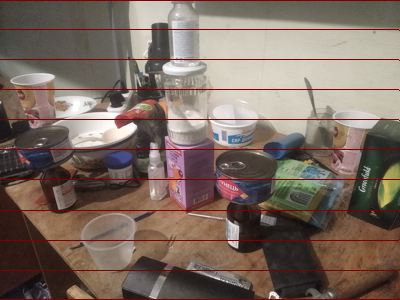

In [255]:
focus_x, focus_y = 200, 150

epipole2 = epipole.reshape(3) + np.array([200, 150, 0])

x_img = 400
for y_img in range(0, 300, 30):
    diff_vector = np.array([x_img, y_img, 1]) - epipole2.reshape(3)
    x_line1, y_line1, z_line1 = epipole2.reshape(3) + (1/3)*diff_vector
    x_line2, y_line2, z_line2 = epipole2.reshape(3) + (2/3)*diff_vector
    
    focus2point = np.array([x_line1, y_line1, z_line1]) - np.array([focus_x, focus_y, 0])
    projected_p1 = np.array([focus_x, focus_y, 0]) + focus2point*(1/focus2point[-1])

    focus2point = np.array([x_line2, y_line2, z_line2]) - np.array([focus_x, focus_y, 0])
    projected_p2 = np.array([focus_x, focus_y, 0]) + focus2point*(1/focus2point[-1])


    projected_diff = projected_p1 - projected_p2

    projected_p1 = projected_p1 - 1000*projected_diff
    projected_p2 = projected_p2 + 1000*projected_diff

    draw.line((*projected_p1[:-1], *projected_p2[:-1]), fill=128)

y_img = 300
for x_img in range(0, 400, 30):
    diff_vector = np.array([x_img, y_img, 1]) - epipole2.reshape(3)
    x_line1, y_line1, z_line1 = epipole2.reshape(3) + (1/3)*diff_vector
    x_line2, y_line2, z_line2 = epipole2.reshape(3) + (2/3)*diff_vector

    focus2point = np.array([x_line1, y_line1, z_line1]) - np.array([focus_x, focus_y, 0])
    projected_p1 = np.array([focus_x, focus_y, 0]) + focus2point*(1/focus2point[-1])

    focus2point = np.array([x_line2, y_line2, z_line2]) - np.array([focus_x, focus_y, 0])
    projected_p2 = np.array([focus_x, focus_y, 0]) + focus2point*(1/focus2point[-1])

    projected_diff = projected_p1 - projected_p2

    projected_p1 = projected_p1 - 1000*projected_diff
    projected_p2 = projected_p2 + 1000*projected_diff

    draw.line((*projected_p1[:-1], *projected_p2[:-1]), fill=128)
    
image2show